# Imports

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from xgboost import XGBClassifier

In [3]:
pd.set_option('display.max_columns', 500)

# Load data

In [4]:
data = pd.read_csv('../data/clickdata.csv')

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


## Preprocess/create features

In [5]:
# Add stratification label
data['stratification'] = data['visitor_recognition_type'] + '_' + data['ua_agent_class']

# Filter out labels with less than min samples
data = data.loc[~data['stratification'].str.contains('RECOGNIZED_Hacker'), :]
data = data.loc[~data['ua_agent_class'].isin(['Cloud Application', 'Mobile App']), :]

# Filling in missing values
data.loc[data['country_by_ip_address'].isna(), 'country_by_ip_address'] = 'UNK'
data.loc[data['region_by_ip_address'].isna(), 'region_by_ip_address'] = 'UNK'
data.loc[data['referrer_without_parameters'].isna(), 'referrer_without_parameters'] = ''

# Splitting class into class and source
data.loc[data['ua_agent_class'] == 'Browser Webview', 'ua_source'] = 'Webview'
data.loc[data['ua_agent_class'] == 'Browser Webview', 'ua_agent_class'] = 'Browser'
data.loc[data['ua_agent_class'] == 'Robot Mobile', 'ua_source'] = 'Mobile'
data.loc[data['ua_agent_class'] == 'Robot Mobile', 'ua_agent_class'] = 'Robot'

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,stratification,ua_source
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,ANONYMOUS_Browser,NaN
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot,ANONYMOUS_Robot Mobile,Mobile


## Parse URLs

In [6]:
def parse_url(url, prefix = 'https://www.bol.com/nl/'):
    url_components = url.removeprefix(prefix).split('/')
    row = {
        'url_function': '',
        'category': '',
        'category_id': '',
        'category_filters': [],
        'n_category_filters': 0,
        'attribute_filters': [],
        'n_attribute_filters': 0,
        'search_type': '',
        'search_text': '',
        'search_context': '',
        'Nty': '',
        'product_id': '',
        'other': '',
        'tracking_id': ''
    }

    if url_components[0] == 'c':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

            if url_components[2].isdigit():
                row['category_id'] = url_components[2]

            else:
                row['category'] = row['category'] + '/' + url_components[2]

                if url_components[3].isdigit():
                    row['category_id'] = url_components[3]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'sc' in url_components:
            index = url_components.index('sc')
            row['search_context'] = url_components[index + 1]

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

    elif url_components[0] == 'checkout':
        row['url_function'] = url_components[0]
        row['other'] = url_components[1]

    elif url_components[0] == 'l':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

    elif url_components[0] == 'order':
        row['url_function'] = url_components[0]
        row['other'] = url_components[1]

    elif url_components[0] == 'p':
        row['url_function'] = url_components[0]
        row['category'] = url_components[1]

        if url_components[2].isdigit():
            row['product_id'] = url_components[2]

    elif url_components[0] == 's':
        row['url_function'] = url_components[0]

        if url_components[1].isdigit():
            row['category_id'] = url_components[1]
        
        else:
            row['category'] = url_components[1]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'Ntt' in url_components:
            index = url_components.index('Ntt')
            row['search_text'] = url_components[index + 1]

        if 'Nty' in url_components:
            index = url_components.index('Nty')
            row['Nty'] = url_components[index + 1]

        if 'sc' in url_components:
            index = url_components.index('sc')
            row['search_context'] = url_components[index + 1]

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

        if 'ajax' in url_components:
            row['other'] = 'ajax'

    elif url_components[0] == 'w':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

            if url_components[2].isdigit():
                row['tracking_id'] = url_components[2]

            else:
                row['category'] = row['category'] + '/' + url_components[2]
                row['tracking_id'] = url_components[3]

            if 'N' in url_components:
                index = url_components.index('N')
                row['category_filters'] = url_components[index + 1].split('+')

            if 'filter_N' in url_components:
                index = url_components.index('filter_N')
                row['attribute_filters'] = url_components[index + 1].split('+')              

    row['n_category_filters'] = len(row['category_filters'])
    row['n_attribute_filters'] = len(row['attribute_filters'])

    return pd.Series(row)

In [7]:
url_features = ['url_function',
                'category',
                'category_id',
                'category_filters',
                'n_category_filters',
                'attribute_filters',
                'n_attribute_filters',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

data[url_features] = data['url_without_parameters'].apply(lambda url: parse_url(url))

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,stratification,ua_source,url_function,category,category_id,category_filters,n_category_filters,attribute_filters,n_attribute_filters,search_type,search_text,search_context,Nty,product_id,other,tracking_id
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN,l,nederlandstalige-kunstgeschiedenis-theorie-ove...,,"[2324, 24596, 8293]",3,[],0,,,,,,,
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN,l,italiaans-natuur-wetenschap-kinderboeken-over-...,,"[24435, 26558, 24670, 7419]",4,[],0,,,,,,,
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,ANONYMOUS_Browser,NaN,p,nespresso-magimix-inissia-m105-koffiemachine-grey,,[],0,[],0,,,,,9200000025533140,,
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN,l,nieuwe-engelstalige-outdoor-sportboeken-algeme...,,"[2806, 4292595594, 4288403245, 4288398652, 140...",6,[4273962351],1,,,,,,,
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot,ANONYMOUS_Robot Mobile,Mobile,l,nieuwe-actie-avontuur-over-prive-detective,,"[33590, 26931, 7289]",3,[],0,,,,,,,


# Base model

In [8]:
X = data[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']].astype('category')

le = LabelEncoder()
y = le.fit_transform(data['ua_agent_class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train, y_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [9]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.98      0.99      0.99      9356
      Hacker       0.00      0.00      0.00       274
       Robot       0.96      0.99      0.97      5279
     Special       1.00      0.12      0.21        34

    accuracy                           0.97     14943
   macro avg       0.73      0.53      0.54     14943
weighted avg       0.95      0.97      0.96     14943



# With stratification

In [126]:
X = data[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']].astype('category')

le = LabelEncoder()
y = le.fit_transform(data['ua_agent_class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

clf = XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train, y_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [127]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.98      0.99      0.99      9327
      Hacker       0.00      0.00      0.00       294
       Robot       0.95      0.99      0.97      5286
     Special       1.00      0.08      0.15        36

    accuracy                           0.97     14943
   macro avg       0.73      0.52      0.53     14943
weighted avg       0.95      0.97      0.96     14943



## With url_function

In [128]:
X = data[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type', 'url_function']].astype('category')

le = LabelEncoder()
y = le.fit_transform(data['ua_agent_class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

clf = XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train, y_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [129]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.98      0.99      0.99      9327
      Hacker       0.62      0.04      0.08       294
       Robot       0.96      0.99      0.98      5286
     Special       1.00      0.08      0.15        36

    accuracy                           0.97     14943
   macro avg       0.89      0.53      0.55     14943
weighted avg       0.97      0.97      0.96     14943



# With URL components

In [130]:
features = ['country_by_ip_address', 
            'region_by_ip_address', 
            'visitor_recognition_type',
            'url_function',
            'category',
            'category_id',
            'n_category_filters',
            'n_attribute_filters',
            'search_type',
            'search_text',
            'search_context',
            'Nty',
            'product_id',
            'other',
            'tracking_id']

cat_features = ['country_by_ip_address', 
                'region_by_ip_address', 
                'visitor_recognition_type',
                'url_function',
                'category',
                'category_id',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

numerical_features = ['n_category_filters',
                        'n_attribute_filters']

X = pd.concat([data[numerical_features],
                data[cat_features].astype('category')], axis=1)

le = LabelEncoder()
y = le.fit_transform(data['ua_agent_class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

clf = XGBClassifier(tree_method="hist", enable_categorical=True)

clf.fit(X_train, y_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [131]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.99      0.99      0.99      9327
      Hacker       0.93      0.60      0.73       294
       Robot       0.97      0.99      0.98      5286
     Special       0.60      0.08      0.15        36

    accuracy                           0.98     14943
   macro avg       0.87      0.67      0.71     14943
weighted avg       0.98      0.98      0.98     14943



# Hyperparameter tuning

In [ ]:
features = ['country_by_ip_address', 
            'region_by_ip_address', 
            'visitor_recognition_type',
            'url_function',
            'category',
            'category_id',
            'n_category_filters',
            'n_attribute_filters',
            'search_type',
            'search_text',
            'search_context',
            'Nty',
            'product_id',
            'other',
            'tracking_id']

cat_features = ['country_by_ip_address', 
                'region_by_ip_address', 
                'visitor_recognition_type',
                'url_function',
                'category',
                'category_id',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

numerical_features = ['n_category_filters',
                        'n_attribute_filters']

X = pd.concat([data[numerical_features],
                data[cat_features].astype('category')], axis=1)

le = LabelEncoder()
y = le.fit_transform(data['ua_agent_class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter search space
param_dist = {
    # Learning rate and trees
    # "n_estimators": [100, 300, 500],
    # "learning_rate": [0.01, 0.05, 0.1, 0.2],

    # # Tree structure
    # "max_depth": [2, 4, 6, 8, 10],
    # "min_child_weight": [1, 3, 5, 7, 9],

    # # Sampling
    # "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    # "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],

    # Regularization
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "reg_alpha": [0, 0.01, 0.05, 0.1, 1, 10],  # L1
    "reg_lambda": [0.1, 0.5, 1, 5, 10],       # L2
}

# TODO: Causes an error. Needs custom implementation
# Required for stratification on multi-column ua_agent_class + visitor_recognition_type
# cv_splitter = skf.split(X, data['stratification'])

scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_weighted": make_scorer(f1_score, average="weighted")
}

clf = XGBClassifier(tree_method="hist", enable_categorical=True)

search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=1000,
    scoring=scoring,
    refit='f1_macro',
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

search_results = search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ..............gamma=0.3, reg_alpha=10, reg_lambda=5; total time=  11.7s
[CV] END ..............gamma=0.3, reg_alpha=10, reg_lambda=5; total time=  11.8s
[CV] END ............gamma=0.2, reg_alpha=0.05, reg_lambda=5; total time=  21.4s
[CV] END ............gamma=0.2, reg_alpha=0.05, reg_lambda=5; total time=  21.8s
[CV] END ............gamma=0.2, reg_alpha=0.05, reg_lambda=5; total time=  21.9s
[CV] END ............gamma=0.2, reg_alpha=0.05, reg_lambda=5; total time=  21.9s
[CV] END ............gamma=0.2, reg_alpha=0.05, reg_lambda=5; total time=  22.2s
[CV] END ..............gamma=0.3, reg_alpha=10, reg_lambda=5; total time=  12.9s
[CV] END ..............gamma=0.3, reg_alpha=10, reg_lambda=5; total time=  13.3s
[CV] END ..............gamma=0.3, reg_alpha=10, reg_lambda=5; total time=  13.8s
[CV] END .............gamma=0.2, reg_alpha=0.1, reg_lambda=5; total time=  24.5s
[CV] END .............gamma=0.2, reg_alpha=0.1

In [ ]:
# joblib.dump(search, '../checkpoints/XGBoost/search/gamma-reg_alpha-reg_lambda.pkl')

['../checkpoints/XGBoost/search/gamma-reg_alpha-reg_lambda.pkl']

## Learning rate and n_estimators

In [76]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_f1_macro').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
4,206.203576,1.937677,1.267994,0.027203,300,0.05,"{'n_estimators': 300, 'learning_rate': 0.05}",0.734722,0.708475,0.707479,0.730474,0.681450,0.712520,0.019091,1,0.981690,0.980339,0.980050,0.980588,0.978890,0.980311,0.000902,3
10,274.196221,6.783726,1.622129,0.171144,300,0.20,"{'n_estimators': 300, 'learning_rate': 0.2}",0.727332,0.709507,0.706785,0.733348,0.682545,0.711904,0.017842,2,0.981152,0.980569,0.979945,0.981083,0.978864,0.980323,0.000848,1
11,284.901324,44.012944,1.598268,0.192241,500,0.20,"{'n_estimators': 500, 'learning_rate': 0.2}",0.727332,0.710011,0.706905,0.730956,0.683682,0.711777,0.016888,3,0.981152,0.980606,0.980010,0.980894,0.978899,0.980312,0.000802,2
3,78.320571,3.262403,0.518842,0.036422,100,0.05,"{'n_estimators': 100, 'learning_rate': 0.05}",0.731971,0.702519,0.706925,0.743395,0.673100,0.711582,0.024546,4,0.981114,0.979625,0.980013,0.979832,0.978088,0.979735,0.000971,10
9,103.776473,1.561774,0.891414,0.367588,100,0.20,"{'n_estimators': 100, 'learning_rate': 0.2}",0.729580,0.708998,0.708012,0.731638,0.678883,0.711422,0.019051,5,0.981430,0.980378,0.980089,0.980901,0.978370,0.980234,0.001038,4


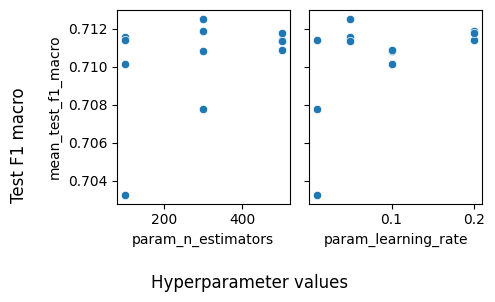

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(5, 3), tight_layout=False)

for i, col in enumerate(['param_n_estimators', 'param_learning_rate']):
    sns.scatterplot(pd.DataFrame(search.cv_results_), 
                    x=col, 
                    y='mean_test_f1_macro', 
                    ax=ax[i])
    ax[i].set_xlabel(col)

fig.supxlabel('Hyperparameter values')
fig.supylabel('Test F1 macro')

plt.show()

## max_depth and min_child_weight

In [92]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_f1_macro').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
8,37.505864,0.444590,0.370999,0.036833,7,4,"{'min_child_weight': 7, 'max_depth': 4}",0.728952,0.709839,0.708978,0.744512,0.676801,0.713817,0.022719,1,0.980771,0.980398,0.979775,0.979952,0.977506,0.979680,0.001142,20
17,93.822720,3.277855,0.623458,0.032188,5,8,"{'min_child_weight': 5, 'max_depth': 8}",0.734187,0.711384,0.706629,0.732017,0.681095,0.713062,0.019347,2,0.981289,0.980513,0.979490,0.980455,0.978276,0.980004,0.001036,5
20,170.100607,3.925628,0.987666,0.084286,1,10,"{'min_child_weight': 1, 'max_depth': 10}",0.726288,0.708997,0.710215,0.734017,0.685384,0.712980,0.016761,3,0.980967,0.980531,0.980151,0.981190,0.978923,0.980353,0.000800,1
11,75.229973,1.497092,0.653158,0.049615,3,6,"{'min_child_weight': 3, 'max_depth': 6}",0.731138,0.709082,0.707410,0.732493,0.681689,0.712362,0.018622,4,0.980945,0.980337,0.979765,0.980635,0.978318,0.980000,0.000927,6
12,70.705155,2.987407,0.521173,0.045046,5,6,"{'min_child_weight': 5, 'max_depth': 6}",0.731154,0.710877,0.706689,0.731242,0.681687,0.712330,0.018357,5,0.980943,0.980475,0.979600,0.980126,0.978317,0.979892,0.000902,7


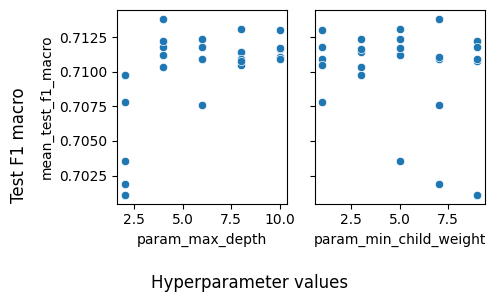

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(5, 3), tight_layout=False)

for i, col in enumerate(['param_max_depth', 'param_min_child_weight']):
    sns.scatterplot(pd.DataFrame(search.cv_results_), 
                    x=col, 
                    y='mean_test_f1_macro', 
                    ax=ax[i])
    ax[i].set_xlabel(col)

fig.supxlabel('Hyperparameter values')
fig.supylabel('Test F1 macro')

plt.show()

## subsample colsample_bytree

In [96]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_f1_macro').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_colsample_bytree,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
15,73.237228,1.136877,0.627274,0.009371,0.6,0.9,"{'subsample': 0.6, 'colsample_bytree': 0.9}",0.729544,0.711564,0.706060,0.748576,0.680506,0.715250,0.022892,1,0.981027,0.980841,0.979623,0.980805,0.978226,0.980104,0.001063,20
22,96.806654,1.433724,0.634628,0.044410,0.8,1.0,"{'subsample': 0.8, 'colsample_bytree': 1.0}",0.725616,0.708987,0.707125,0.748547,0.680530,0.714161,0.022454,2,0.981020,0.980422,0.980344,0.980691,0.978285,0.980152,0.000963,14
13,69.863375,1.364425,0.671695,0.071809,0.9,0.8,"{'subsample': 0.9, 'colsample_bytree': 0.8}",0.734070,0.709651,0.709129,0.730397,0.681734,0.712996,0.018710,3,0.981586,0.980636,0.979790,0.980479,0.978430,0.980184,0.001048,10
11,64.415533,0.656145,0.612697,0.014387,0.7,0.8,"{'subsample': 0.7, 'colsample_bytree': 0.8}",0.733011,0.708536,0.708696,0.732847,0.681680,0.712954,0.019046,4,0.981559,0.980449,0.979973,0.980882,0.978370,0.980246,0.001074,2
16,76.420136,0.612377,0.630796,0.015707,0.7,0.9,"{'subsample': 0.7, 'colsample_bytree': 0.9}",0.731722,0.711349,0.708758,0.731054,0.681794,0.712935,0.018281,5,0.981352,0.980555,0.980084,0.980585,0.978540,0.980223,0.000935,5


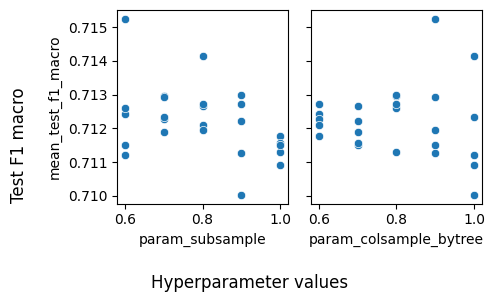

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(5, 3), tight_layout=False)

for i, col in enumerate(['param_subsample', 'param_colsample_bytree']):
    sns.scatterplot(pd.DataFrame(search.cv_results_), 
                    x=col, 
                    y='mean_test_f1_macro', 
                    ax=ax[i])
    ax[i].set_xlabel(col)

fig.supxlabel('Hyperparameter values')
fig.supylabel('Test F1 macro')

plt.show()

## gamma reg_alpha reg_lambda

In [101]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_f1_macro').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,param_reg_alpha,param_gamma,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
13,64.726602,2.306476,0.507933,0.021194,10.0,0.01,0.0,"{'reg_lambda': 10, 'reg_alpha': 0.01, 'gamma': 0}",0.731760,0.709930,0.708773,0.754046,0.685417,0.717985,0.023240,1,0.981196,0.980771,0.980082,0.981492,0.979082,0.980525,0.000863,1
1,55.344044,0.968201,0.474205,0.014245,5.0,0.10,0.0,"{'reg_lambda': 5, 'reg_alpha': 0.1, 'gamma': 0}",0.733538,0.709782,0.709298,0.751667,0.683743,0.717606,0.023199,2,0.981440,0.980704,0.980125,0.981203,0.979009,0.980496,0.000870,2
97,151.462475,1.956592,0.838626,0.169123,5.0,0.05,0.0,"{'reg_lambda': 5, 'reg_alpha': 0.05, 'gamma': 0}",0.730625,0.709929,0.708773,0.754046,0.683620,0.717399,0.023618,3,0.981056,0.980769,0.980082,0.981492,0.978787,0.980437,0.000944,5
30,66.893033,1.036401,0.503144,0.025080,1.0,1.00,0.0,"{'reg_lambda': 1, 'reg_alpha': 1, 'gamma': 0}",0.733663,0.705628,0.706821,0.751435,0.681847,0.715879,0.024190,4,0.981404,0.979920,0.979948,0.981023,0.978598,0.980178,0.000983,22
81,50.732348,0.966920,0.332020,0.021212,10.0,0.10,0.1,"{'reg_lambda': 10, 'reg_alpha': 0.1, 'gamma': ...",0.734914,0.709405,0.708841,0.747912,0.678185,0.715851,0.024086,5,0.981760,0.980732,0.980356,0.980541,0.978098,0.980297,0.001203,9


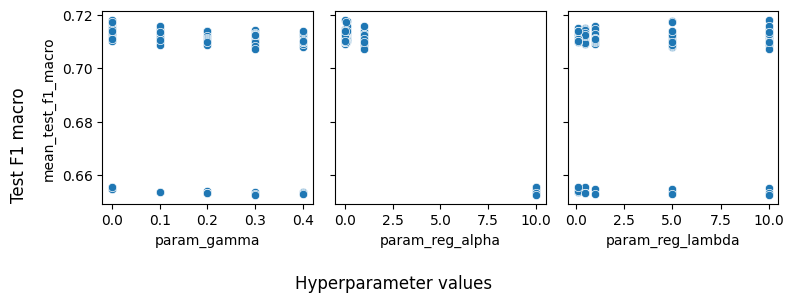

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(8, 3), tight_layout=False)

for i, col in enumerate(['param_gamma', 'param_reg_alpha', 'param_reg_lambda']):
    sns.scatterplot(pd.DataFrame(search.cv_results_), 
                    x=col, 
                    y='mean_test_f1_macro', 
                    ax=ax[i])
    ax[i].set_xlabel(col)

fig.supxlabel('Hyperparameter values')
fig.supylabel('Test F1 macro')

plt.show()

## Aggregate of all searches

In [112]:
import os
from pprint import pprint

best_params = {}
for filename in os.listdir('../checkpoints/XGBoost/search'):
    search = joblib.load(f"../checkpoints/XGBoost/search/{filename}")
    best_params.update(search.best_params_)

pprint(best_params)

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 7,
 'n_estimators': 300,
 'reg_alpha': 0.01,
 'reg_lambda': 10,
 'subsample': 0.6}


In [113]:
clf = XGBClassifier(tree_method="hist", enable_categorical=True, **best_params)

clf.fit(X_train, y_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [114]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       1.00      0.99      0.99      9328
      Hacker       0.87      0.55      0.67       294
       Robot       0.96      0.99      0.98      5285
     Special       0.89      0.22      0.36        36

    accuracy                           0.98     14943
   macro avg       0.93      0.69      0.75     14943
weighted avg       0.98      0.98      0.98     14943



# SHAP analysis

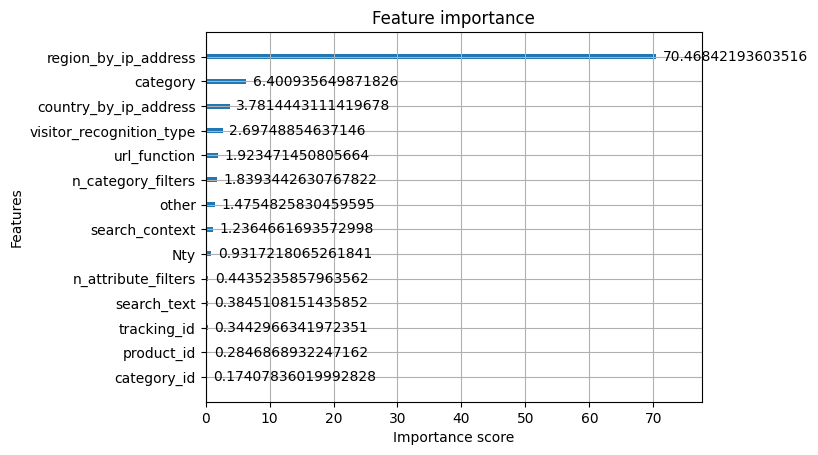

In [134]:
import xgboost

xgboost.plot_importance(clf, importance_type='gain')

plt.show()